In [1]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions

In [2]:
function OUH(x0::Float64,γ::Float64,η::Float64,t::AbstractArray,cte::Float64=0.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)                 #Usamos un for para poder hacer el proceso
        x0=x0-(x0*γ)+(η*randn())+cte # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 2 methods)

In [3]:
function eigen2(n::Int64,γK::Float64,K::Array{Float64,1}) #Obtenemos los eigenvalores y eigenvectores 
    R=diagm(0 =>ones(2))                                #Hacemos una matriz llena de unos en la diagonal de dimension 2
    for i=1:n                                           #Hacemos un for donde n es la cantidad de pasos de t, pasos de tiempo
       R=(diagm(0 => ones(2))+diagm(1 => [K[i]]*γK,-1 => -[K[i]]*γK)+(0.5*diagm(1 => [K[i]]*γK,-1 => -[K[i]]*γK)^2))*R #Hacemos los pasos de multiplicar la matriz por la matriz anterior 
    end
    eigen(R)#Obtenemos el eigenvalor y eigenvector
end

function eigen2(n::Int64,γK::Float64,K::Array{Float64,1},T::Array{Float64,1}) 
    R=diagm(0 =>ones(3)) #Hacemos una matriz llena de unos en la diagonal de dimension 2
    for i=1:n            #Hacemos un for donde n es la cantidad de pasos de t, pasos de tiempo
       R=(diagm(0 => ones(3))+diagm(1 => [K[i],T[i]]*γK,-1 => -[K[i],T[i]]*γK)+(0.5*diagm(1 => [K[i],T[i]]*γK,-1 => -[K[i],T[i]]*γK)^2))*R #Hacemos los pasos de multiplicar la matriz por la matriz anterior 
    end
    eigen(R) #Obtenemos el eigenvalor y eigenvector
end

eigen2 (generic function with 2 methods)

In [4]:
function lam_eigenvals(γK::Float64,t::AbstractArray,tiradas::Int64,ηK::Float64,k0::Float64,ctek::Float64=0.0) #Da una lista de eigenvalores de todas las tiradas
    λ=Vector{Complex{Float64}}(undef,2*tiradas) #Nos hace una lista llena de basura para renombrar sus valores
    for i=1:tiradas             #Un for con la cantidad de tiradas
        K=OUH(k0,γK,ηK,t,ctek)        #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        a=eigen2(length(t),γK,K).values #Obtenemos los eigenvalores de cada tirada
        @inbounds λ[2*i-1]=a[1] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[2*i-0]=a[2] #Reescribirmos la basura con los eigenvalores
    end
    return λ   #Devolvemos la lista de eigenvalores
end

function lam_eigenvals(γ::Array{Float64,1},t::AbstractArray,tiradas::Int64,η::Array{Float64,1},x0::Array{Float64,1},cte::Array{Float64,1}=[0.0,0.0])
    λ=Vector{Complex{Float64}}(undef,3*tiradas) #Nos hace una lista llena de basura para renombrar sus valores
    for i=1:tiradas #Un for con la cantidad de tiradas
        K=OUH(x0[1],γ[1],η[1],t,cte[1]) #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        T=OUH(x0[2],γ[2],η[2],t,cte[2]) #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        a=eigen2(length(t),Δt,K,T).values #Obtenemos los eigenvalores de cada tirada
        @inbounds λ[3*i-2]=a[1] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[3*i-1]=a[2] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[3*i-0]=a[3] #Reescribirmos la basura con los eigenvalores
    end
    return λ
end

lam_eigenvals (generic function with 4 methods)

In [5]:
function lam_eigenvals_C(λ::Array{Complex{Float64},1})
    λr=Complex{Float64}[]
    for i=1:length(λ)
        if imag(λ[i]) != 0
            push!(λr,λ[i])
        end
    end
    return λr
end
function lam_eigenvals_R(λ::Array{Complex{Float64},1})
    λr=Float64[]
    for i=1:length(λ)
        if imag(λ[i]) == 0
            push!(λr,λ[i])
        end
    end
    return λr
end

lam_eigenvals_R (generic function with 1 method)

In [6]:
function ev_vector_eje(n::Int64,γK::Float64,K::Array{Float64,1},T::Array{Float64,1})
    v=Array{Float64,1}[]
    for j=1:n
        for i=1:3
            a=imag.(vec((eigen2(j,γK,K,T).vectors)[i:i, 1:3]))
            if a==[0.0,0.0,0.0]
                push!(v,real.(vec((eigen2(j,γK,K,T).vectors)[i:i, 1:3])))
            end
        end
    end
    return v
end


function vector_eje_en_TiempoN(paso::Int64,tiradas::Int64,t::AbstractArray,k0::Float64,γK::Float64,ηK::Float64,ctek::Float64,t0::Float64,γT::Float64,ηT::Float64,ctet::Float64)
    v=Array{Float64,1}[]
    for j=1:tiradas
        K=OUH(k0,γK,ηK,t,ctek) 
        T=OUH(t0,γT,ηT,t,ctet)
        for i=1:3
            a=imag.(vec((eigen2(paso,γK,K,T).vectors)[i:i, 1:3]))
            if a==[0.0,0.0,0.0]
                push!(v,real.(vec((eigen2(paso,γK,K,T).vectors)[i:i, 1:3])))
            end
        end
    end
    return v
end

vector_eje_en_TiempoN (generic function with 1 method)

In [7]:
k0=1.0
t0=1.0

γK=0.001

γT=1.0

ηK=1.0
ηT=1.0


N=6.0

t=0:γK:N

ctek=0.0
ctet=0.0

#para animar
tiradas=500
step=300 
length(1:step:length(t))


21

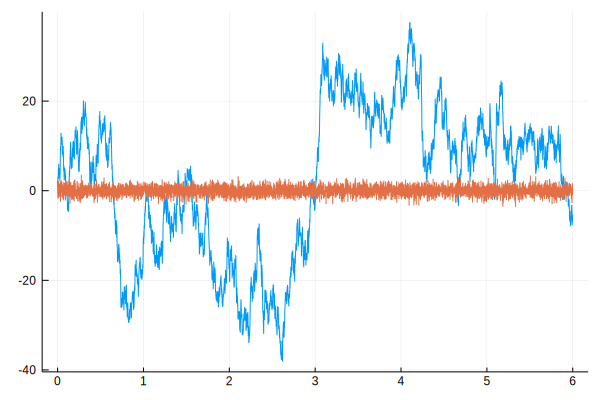

In [8]:
plot(t,OUH(k0,γK,ηK,t,ctek),legend=false)
plot!(t,OUH(t0,γT,ηT,t,ctet),legend=false)